#### Libraries

In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import random
random.seed(0)

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

%matplotlib inline
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8

# from pandas_profiling import ProfileReportofileReport

import warnings

warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

In [4]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    false_positive_rate,
    true_positive_rate,
    count,
)
import shap

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.cat_boost import CatBoostEncoder

from tqdm.notebook import tqdm
from collections import defaultdict

## Data Loading and helper functions

In [5]:
df = pd.read_csv("data/compas-scores-raw.csv")

df["Score"] = df["DecileScore"]

df.loc[df["DecileScore"] > 4, "Score"] = 1
df.loc[df["DecileScore"] <= 4, "Score"] = 0

df.loc[df['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'

cols = [
    "Person_ID",
    "AssessmentID",
    "Case_ID",
    "LastName",
    "FirstName",
    "MiddleName",
    "DateOfBirth",
    "ScaleSet_ID",
    "Screening_Date",
    "RecSupervisionLevel",
    #"Agency_Text",
    #"AssessmentReason",
    "Language",
    "Scale_ID",
    #"IsCompleted",
    #"IsDeleted",
    #"AssessmentType",
    "DecileScore",
    "RecSupervisionLevelText",
    #"DisplayText",
    #"ScaleSet",
    #"LegalStatus",
    #"CustodyStatus",

]


df = df.drop(columns=cols)

possible_targets = ["RawScore", "ScoreText", "Score"]

X = df.drop(columns=possible_targets)
y = df[["Score"]]

In [6]:
X['Sex_Code_Text'] = pd.get_dummies(X['Sex_Code_Text'],prefix='Sex')['Sex_Male']
X["ScaleSet"] = pd.get_dummies(X['ScaleSet'])['Risk and Prescreen']

In [7]:
X.columns = [
    "Agency_Text",
    "Sex",
    "Ethnic",
    "ScaleSet",
    "AssessmentReason",
    "LegalStatus",
    "CustodyStatus",
    "MaritalStatus",
    "DisplayText",
    "AssessmentType",
    "IsCompleted",
    "IsDeleted",
]

In [8]:
y.value_counts(normalize=True)

Score
0        0.682609
1        0.317391
dtype: float64

In [9]:
aux = X.copy()
aux['score'] = y
print(aux.groupby('Ethnic').score.mean())
del aux

Ethnic
African-American    0.427352
Arabic              0.226667
Asian               0.141975
Caucasian           0.248083
Hispanic            0.202471
Native American     0.360731
Oriental            0.153846
Other               0.162423
Name: score, dtype: float64


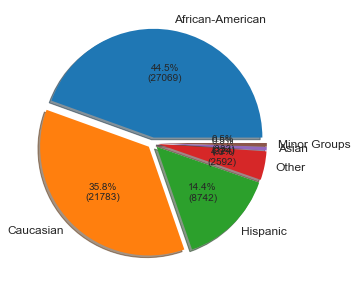

In [10]:
# Remove groups that have small statistical mass
filter_value = 323

aux = pd.DataFrame(X["Ethnic"].value_counts())
aux2 = pd.DataFrame(data = {'Ethnic': aux[aux.Ethnic<filter_value].sum()[0]},index=['Minor Groups'])
aux = aux.append(aux2)
aux = aux[aux.Ethnic>=filter_value]


def func(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


colors = sns.color_palette("pastel")[0 : aux.shape[0]]


# create pie chart
plt.figure()
explode =  (0.05,)* aux.shape[0] 

plt.pie(
    aux.Ethnic.values,
    labels=aux.index,
    autopct=lambda pct: func(pct, aux.Ethnic.values),
    shadow=True,
    explode=explode,
)

plt.show()

In [11]:
for col in X.columns:
    print(X[col].value_counts())

PRETRIAL          41100
Probation         19056
DRRD                564
Broward County      123
Name: Agency_Text, dtype: int64
1    47514
0    13329
Name: Sex, dtype: int64
African-American    27069
Caucasian           21783
Hispanic             8742
Other                2592
Asian                 324
Native American       219
Arabic                 75
Oriental               39
Name: Ethnic, dtype: int64
1    58647
0     2196
Name: ScaleSet, dtype: int64
Intake    60843
Name: AssessmentReason, dtype: int64
Pretrial               37578
Post Sentence          18333
Other                   4356
Conditional Release      420
Probation Violator       126
Parole Violator           18
Deferred Sentencing       12
Name: LegalStatus, dtype: int64
Jail Inmate            30129
Probation              22968
Pretrial Defendant      7644
Residential Program       66
Parole                    21
Prison Inmate             15
Name: CustodyStatus, dtype: int64
Single               45126
Married          

In [12]:
for col in X.columns:
    print(len(X[col].unique()))

4
2
8
2
1
7
6
7
3
2
1
1


In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=42)

In [14]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = "", min_samples: int = 10):

    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].value_counts()
    cats = cats[cats > min_samples].index.tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        elif cat == "all":
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))
        else:
            pass

    return dicc

In [15]:
def explain(xgb: bool = True):
    """
    Provide a SHAP explanation by fitting MEstimate and GBDT
    """
    if xgb:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", GradientBoostingClassifier())]
        )
        pipe.fit(X_tr, y_tr)
        explainer = shap.Explainer(pipe[1])
        shap_values = explainer(pipe[:-1].transform(X_tr))
        shap.plots.beeswarm(shap_values)
        return pd.DataFrame(np.abs(shap_values.values), columns=X_tr.columns).sum()
    else:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", LogisticRegression())]
        )
        pipe.fit(X_tr, y_tr)
        coefficients = pd.concat(
            [pd.DataFrame(X_tr.columns), pd.DataFrame(np.transpose(pipe[1].coef_))],
            axis=1,
        )
        coefficients.columns = ["feat", "val"]

        return coefficients.sort_values(by="val", ascending=False)

In [16]:
def calculate_cm(true, preds):
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    ##########
    ## I AM NOT SURE ABOUT THIS 0 INDEX
    ###########
    return TPR[0]

In [17]:
def metric_calculator(
    modelo, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1: str, group2: str
):
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = modelo.predict(g1)
    p2 = modelo.predict(g2)

    # Extract metrics for each group
    res1 = calculate_cm(p1, g1_true)
    res2 = calculate_cm(p2, g2_true)
    return res1 - res2

In [18]:
m = Pipeline([('enc',CatBoostEncoder(sigma=0.5)),('model',LogisticRegression())])
m.fit(X_tr,y_tr)

Pipeline(steps=[('enc',
                 CatBoostEncoder(cols=['Agency_Text', 'Ethnic',
                                       'AssessmentReason', 'LegalStatus',
                                       'CustodyStatus', 'MaritalStatus',
                                       'DisplayText', 'AssessmentType'],
                                 sigma=0.5)),
                ('model', LogisticRegression())])

In [19]:
roc_auc_score(y_te,m.predict_proba(X_te)[:,1])

0.6862900016131274

In [20]:
res = {}
for cat,num in X['Ethnic'].value_counts().items():
    COL = "Ethnic"
    GROUP1 = "Asian"
    GROUP2 = cat
    res[cat] = [metric_calculator(modelo=m,data = X, truth = y,col=COL,group1=GROUP1,group2 =GROUP2),num]
    

In [21]:
res = pd.DataFrame(res).T

res.columns=['fairness','items']

res['items']= res['items'].astype(int)

In [22]:
res

,fairness,items
African-American,0.026837,27069
Caucasian,0.013188,21783
Hispanic,0.009323,8742
Other,0.002764,2592
Asian,0.000000,324
Native American,0.021429,219
Arabic,0.034483,75
Oriental,0.000000,39


In [23]:
def plot_rolling(data, roll_mean: int = 5, roll_std: int = 20):

    aux = data.rolling(roll_mean).mean().dropna()
    stand = data.rolling(roll_std).quantile(0.05, interpolation="lower").dropna()
    plt.figure()
    for col in data.columns:
        plt.plot(aux[col], label=col)
        # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
    plt.legend()
    plt.show()

In [24]:
def scale_output(data):
    return pd.DataFrame(
        StandardScaler().fit_transform(data), columns=data.columns, index=data.index
    )

# Experiment

In [25]:
def fair_encoder(model, param: list, enc: str = "mestimate", un_regularize: list = []):
    auc = {}
    metrica = []
    auc_tot = []

    allowed_enc = [
        "mestimate",
        "targetenc",
        "leaveoneout",
        "ohe",
        "woe",
        "james",
        "catboost",
    ]
    assert (
        enc in allowed_enc
    ), "Encoder not available or check for spelling mistakes: {}".format(allowed_enc)

    cols_enc = set(X_tr.columns) - set(un_regularize)

    for m in tqdm(param):
        if enc == "mestimate":
            encoder = Pipeline(
                [
                    ("reg", MEstimateEncoder(m=m, cols=cols_enc)),
                    ("unreg", MEstimateEncoder(m=0, cols=un_regularize)),
                ]
            )
        elif enc == "targetenc":
            encoder = TargetEncoder(smoothing=m)
        elif enc == "leaveoneout":
            encoder = Pipeline(
                [
                    ("reg", LeaveOneOutEncoder(sigma=m, cols=cols_enc)),
                    ("unreg", LeaveOneOutEncoder(sigma=0, cols=un_regularize)),
                ]
            )
        elif enc == "ohe":
            encoder = OneHotEncoder(handle_missing=-1)
        elif enc == "woe":
            encoder = WOEEncoder(randomized=True, sigma=m)
        elif enc == "james":
            encoder = JamesSteinEncoder(randomized=True, sigma=m)
        elif enc == "catboost":
            encoder = Pipeline(
                [
                    ("reg", CatBoostEncoder(a=1, sigma=m, cols=cols_enc)),
                    ("unreg", CatBoostEncoder(a=1, sigma=0, cols=un_regularize)),
                ]
            ) 

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_te)

        metrica.append(
            metric_calculator(
                modelo=pipe,
                data=X_tr,
                truth=y_tr,
                col=COL,
                group1=GROUP1,
                group2=GROUP2,
            )
        )
        auc = auc_group(model=pipe, data=X_te, y_true=y_te, dicc=auc, group=COL)
        auc_tot.append(roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1]))

    # Results formatting
    res = pd.DataFrame(index=param)
    res["fairness_metric"] = metrica
    res["auc_tot"] = auc_tot
    res["auc_" + GROUP1] = auc[GROUP1]
    res["auc_" + GROUP2] = auc[GROUP2]

    return res

In [26]:
# Experiment parameters
COL = "Ethnic"
GROUP1 = "African-American"
GROUP2 = "Caucasian"

In [27]:
cols_enc = ['Agency_Text', 'Sex', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted']

In [28]:
## LR
one_hot1 = fair_encoder(model=LogisticRegression(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus1 = fair_encoder(model=LogisticRegression(), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 100, 50)
smooth1 = fair_encoder(model=LogisticRegression(), enc="mestimate", param=PARAM,un_regularize=cols_enc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

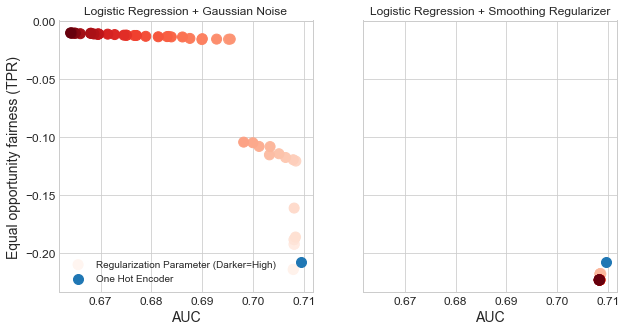

In [29]:
fig, axs = plt.subplots(1, 2,  sharex=True, sharey=True)

#LR
axs[0].set_title("Logistic Regression + Gaussian Noise")
axs[0].scatter(
    gaus1["auc_tot"].values,
    gaus1["fairness_metric"].values,
    s=100,
    c=gaus1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
axs[0].legend()

axs[0].set(xlabel="AUC")
axs[1].set(xlabel="AUC")
axs[0].set(ylabel="Equal opportunity fairness (TPR)")


axs[1].set_title("Logistic Regression + Smoothing Regularizer")
axs[1].scatter(
    smooth1["auc_tot"].values,
    smooth1["fairness_metric"].values,
    s=100,
    c=smooth1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
fig.savefig('images/encTheory.eps',format='eps')
fig.show()

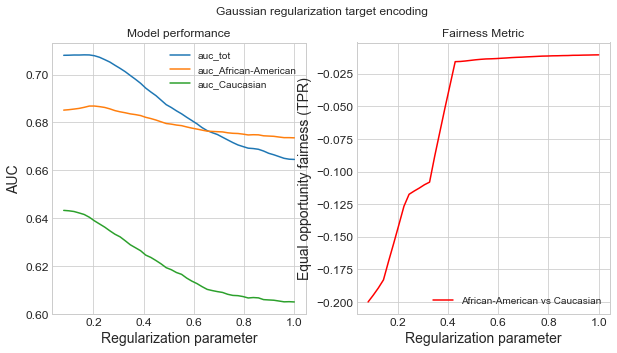

In [30]:
fig, axs = plt.subplots(1, 2,sharex=True)

fig.suptitle("Gaussian regularization target encoding")
aux = (
    gaus1[["auc_tot", "auc_African-American", "auc_Caucasian"]]
    .rolling(5)
    .mean()
    .dropna()
)


for col in aux.columns:
    axs[0].plot(aux[col], label=col)
    # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
axs[0].legend()
axs[0].set_title("Model performance")
axs[0].set_ylabel("AUC")
axs[0].set_xlabel("Regularization parameter")

aux = gaus1[["fairness_metric"]].rolling(5).mean().dropna()

axs[1].plot(aux['fairness_metric'], label=GROUP1+' vs '+ GROUP2,color='r')

axs[1].legend()
axs[1].set_title("Fairness Metric")
axs[1].set_ylabel("Equal opportunity fairness (TPR)")
axs[1].set_xlabel("Regularization parameter")
plt.savefig('images/compassHyperGaussian.eps',format='eps')
plt.show()

In [31]:
## LR
#one_hot1 = fair_encoder(model=LogisticRegression(), enc="ohe", param=[0])

#PARAM = np.linspace(0, 1, 50)
#gaus1 = fair_encoder(model=LogisticRegression(), enc="catboost", param=PARAM,un_regularize=cols_enc)
#PARAM = np.linspace(0, 100, 50)
#smooth1 = fair_encoder(model=LogisticRegression(), enc="mestimate", param=PARAM,un_regularize=cols_enc)
## DT
one_hot2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="ohe", param=[0])
PARAM = np.linspace(0, 1, 50)
gaus2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 100, 50)
smooth2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="mestimate", param=PARAM,un_regularize=cols_enc)
## GBDT
one_hot3 = fair_encoder(model=GradientBoostingClassifier(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus3 = fair_encoder(model=GradientBoostingClassifier(), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 100, 50)
smooth3 = fair_encoder(model=GradientBoostingClassifier(), enc="mestimate", param=PARAM,un_regularize=cols_enc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

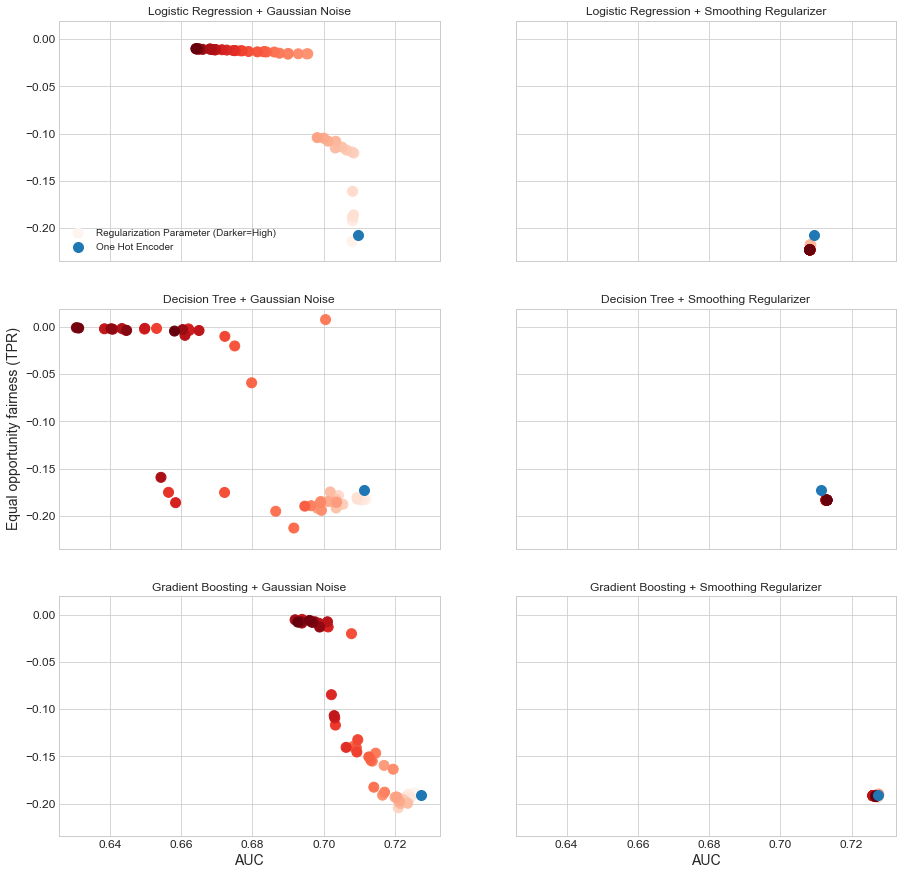

In [32]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=True, sharey=True)

#LR
axs[0, 0].set_title("Logistic Regression + Gaussian Noise")
#axs[0, 0].axis(xmin=0.5,xmax=13.5)
axs[0, 0].scatter(
    gaus1["auc_tot"].values,
    gaus1["fairness_metric"].values,
    s=100,
    c=gaus1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0, 0].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
axs[0,0].legend()
axs[0, 1].set_title("Logistic Regression + Smoothing Regularizer")
axs[0, 1].scatter(
    smooth1["auc_tot"].values,
    smooth1["fairness_metric"].values,
    s=100,
    c=smooth1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0, 1].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)

## DT
axs[1, 0].set_title("Decision Tree + Gaussian Noise")
axs[1, 0].set(ylabel="Equal opportunity fairness (TPR)")
axs[1, 0].scatter(
    gaus2["auc_tot"].values,
    gaus2["fairness_metric"].values,
    s=100,
    c=gaus2.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1, 0].scatter(
    y=one_hot2.fairness_metric, x=one_hot2.auc_tot, s=100, label="One Hot Encoder"
)

axs[1, 1].set_title("Decision Tree + Smoothing Regularizer")
axs[1, 1].scatter(
    smooth2["auc_tot"].values,
    smooth2["fairness_metric"].values,
    s=100,
    c=smooth2.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1, 1].scatter(
    y=one_hot2.fairness_metric, x=one_hot2.auc_tot, s=100, label="One Hot Encoder"
)

# GBDT
axs[2, 0].set_title("Gradient Boosting + Gaussian Noise")
axs[2, 0].set(xlabel="AUC")
axs[2, 0].scatter(
    gaus3["auc_tot"].values,
    gaus3["fairness_metric"].values,
    s=100,
    c=gaus3.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[2, 0].scatter(
    y=one_hot3.fairness_metric, x=one_hot3.auc_tot, s=100, label="One Hot Encoder"
)

axs[2, 1].set_title("Gradient Boosting + Smoothing Regularizer")
axs[2, 1].set(xlabel="AUC")
axs[2, 1].scatter(
    smooth3["auc_tot"].values,
    smooth3["fairness_metric"].values,
    s=100,
    c=smooth3.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[2, 1].scatter(
    y=one_hot3.fairness_metric, x=one_hot3.auc_tot, s=100, label="One Hot Encoder"
)

fig.savefig('images/encTheoryFull.eps',format='eps')
fig.show()

In [33]:
kk

NameError: name 'kk' is not defined

# Time evaluation

## Logistic

In [ ]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',LogisticRegression())])

In [ ]:
%%timeit -n 10
fast.fit(X,y)


In [ ]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',LogisticRegression())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',OneHotEncoder()),('model',LogisticRegression())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',LeaveOneOutEncoder(sigma=1)),('model',LogisticRegression())])

In [ ]:
%%timeit -n 10
fast.fit(X,y)

## Decision Tree

In [ ]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',DecisionTreeClassifier())])

In [ ]:
%%timeit -n 10
fast.fit(X,y)


In [ ]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',DecisionTreeClassifier())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',OneHotEncoder()),('model',DecisionTreeClassifier())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',LeaveOneOutEncoder(sigma=1)),('model',DecisionTreeClassifier())])

In [ ]:
%%timeit -n 10
fast.fit(X,y)

## GBDT

In [ ]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',GradientBoostingClassifier())])

In [ ]:
%%timeit -n 10
fast.fit(X,y)


In [ ]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',GradientBoostingClassifier())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',OneHotEncoder()),('model',GradientBoostingClassifier())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)

In [ ]:
fast = Pipeline([('enc',LeaveOneOutEncoder(sigma=1)),('model',GradientBoostingClassifier())])


In [ ]:
%%timeit -n 10
fast.fit(X,y)